# Alamouti Space-time block code

This notebook illustrates the simulation of an Alamouti MIMO scheme transmission through a flat fading Rayleight channel.

It also illustrates how to read configuration from a config file.

We simulate the Alamouti STBC with a 16-QAM modulation, as well as BPSK modulation.

## Initializations

In [24]:
%matplotlib inline
import numpy as np
from IPython.display import clear_output
from matplotlib import pyplot as plt

Because there is already an Alamouti simulator implemented in the "apps" folder of pyphysim, we simple import it here and set the desired simulation parameters. You should inspect the `apps/mimo/simulate_mimo.py` file for more, including reading parameters from a configuration file.

In [25]:
from pyphysim.modulators.fundamental import BPSK, QAM
from apps.mimo.simulate_mimo import AlamoutiSimulationRunner, plot_ber, plot_ser, plot_ber_and_ser

## Simulation of Alamouti with 16-QAM

First we create the SimulationRunner objects. Note that the actual simulator is already implemented as an application in PyPhysim and we are only setting the parameters here.

In [26]:
sim = AlamoutiSimulationRunner('mimo_alamouti_config_file.txt', read_command_line_args=False)
sim.NSymbs = 300
sim.rep_max = 10000
sim.params.add('SNR', np.linspace(0, 25, 11))
sim.modulator = QAM(16)
sim.Nr=1
sim.update_progress_function_style = 'ipython'
sim.progressbar_message = 'Simulating for SNR {SNR}'
# max_bit_errors is used in the _keep_going method to stop the
# simulation earlier if possible. We stop the simulation if the
# accumulated number of bit errors becomes greater then 0.1% of the
# total number of simulated bits
sim.max_bit_errors = sim.rep_max * sim.NSymbs * 0.01
sim.clear()

sim2 = AlamoutiSimulationRunner('mimo_alamouti_config_file.txt', read_command_line_args=False)
sim2.NSymbs = 300
sim2.rep_max = 10000
sim2.params.add('SNR', np.linspace(0, 25, 11))
sim2.modulator = QAM(16)
sim2.Nr=2
sim2.update_progress_function_style = 'ipython'
sim2.progressbar_message = 'Simulating for SNR {SNR}'
sim2.max_bit_errors = sim2.rep_max * sim2.NSymbs * 0.01
sim2.clear()

In [27]:
print(sim.params)
print(sim2.params)

{'SNR*': [ 0.   2.5  5.   7.5 10.  12.5 15.  17.5 20.  22.5 25. ], 'M': 16, 'modulator': QAM, 'NSymbs': 200, 'Nr': 1, 'Nt': 2, 'rep_max': 5000, 'max_bit_errors': 5000, 'unpacked_parameters': ['SNR']}
{'SNR*': [ 0.   2.5  5.   7.5 10.  12.5 15.  17.5 20.  22.5 25. ], 'M': 16, 'modulator': QAM, 'NSymbs': 200, 'Nr': 1, 'Nt': 2, 'rep_max': 5000, 'max_bit_errors': 5000, 'unpacked_parameters': ['SNR']}


During the simulation, we are only interested in the progressbar output for simulation of the current parameters. Therefore, lets set the _on_simulate_current_params_finish method of the SimulationRunner objects to a function that erases all the output from the cell.

In [28]:
def clear_ipython_output(dummy1, dummy2=None):
    clear_output()

# Lets create a custom method to clear the output after the simulation of each combination of parameters
sim._on_simulate_current_params_finish = clear_ipython_output
sim2._on_simulate_current_params_finish = clear_ipython_output

Now we can run the simulations.

First we run the simulations for **NRx=1** with **16-QAM** modulation

In [29]:
sim.simulate()
clear_output()
print("Elapsed Time for simulation 1: {0}".format(sim.elapsed_time))

Elapsed Time for simulation 1: 1m:19s


and then we run the simulations for **NRx=2** with **16-QAM** modulation.

In [30]:
sim2.simulate()
clear_output()
print("Elapsed Time for simulation 2: {0}".format(sim2.elapsed_time))

Elapsed Time for simulation 2: 1m:21s


### Plot the Results

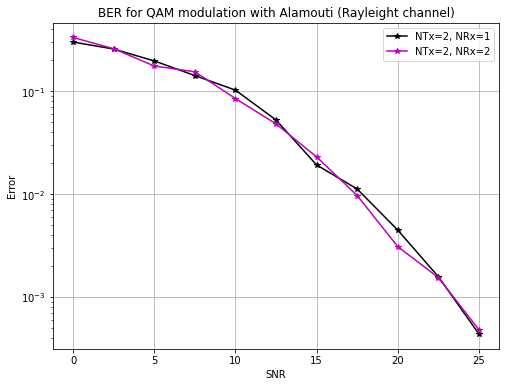

In [31]:
SNR = np.array(sim.results.params['SNR'])
ber = sim.results.get_result_values_list('ber')
ser = sim.results.get_result_values_list('ser')

fig, ax = plt.subplots(figsize=(8,6))
ax.semilogy(SNR, ber, '-k*', label='NTx=2, NRx=1')

ber2 = sim2.results.get_result_values_list('ber')
ser2 = sim2.results.get_result_values_list('ser')
ax.semilogy(SNR, ber2, '-m*', label='NTx=2, NRx=2')

ax.set_xlabel('SNR')
ax.set_ylabel('Error')
ax.set_title('BER for QAM modulation with Alamouti (Rayleight channel)'.format(sim.modulator.name))
ax.legend()

#grid(True, which='both', axis='both')
ax.grid()
# fig.show()

----------------------------

## Simulation of Alamouti with BPSK

Now lets repeat the simulation, but for BPSK modulation.
We can use the same SimulationRunner objects and only change the modulator, but we also need to call the "clear" method in both objects toerase results from the previous simulation.

In [32]:
sim.modulator = BPSK()
sim2.modulator = BPSK()

sim.clear()   # Erase results from the previous simulation with 16-QAM
sim2.clear()  # Erase results from the previous simulation with 16-QAM

Now we can run the simulations.

First we run the simulations for **NRx=1** with **BPSK** modulation

In [33]:
sim.simulate()
clear_output()
print("Elapsed Time for simulation 1: {0}".format(sim.elapsed_time))

Elapsed Time for simulation 1: 4m:27s


and then we run the simulations for **NRx=2** with **BPSK** modulation.

In [34]:
sim2.simulate()
clear_output()
print("Elapsed Time for simulation 2: {0}".format(sim2.elapsed_time))

Elapsed Time for simulation 2: 4m:43s


### Plot the Results

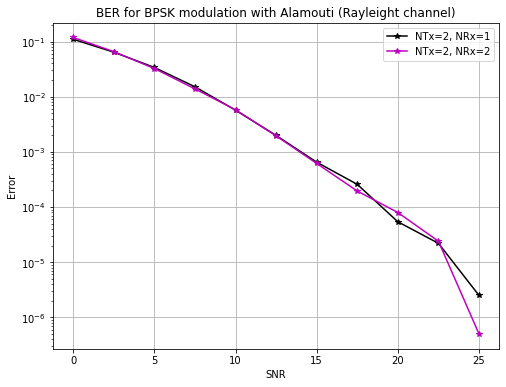

In [35]:
SNR = np.array(sim.results.params['SNR'])
ber = sim.results.get_result_values_list('ber')
ser = sim.results.get_result_values_list('ser')
len(SNR)

fig2, ax2 = plt.subplots(figsize=(8,6))
ax2.semilogy(SNR, ber, '-k*', label='NTx=2, NRx=1')

ber2 = sim2.results.get_result_values_list('ber')
ser2 = sim2.results.get_result_values_list('ser')
ax2.semilogy(SNR, ber2, '-m*', label='NTx=2, NRx=2')

ax2.set_xlabel('SNR')
ax2.set_ylabel('Error')
ax2.set_title('BER for BPSK modulation with Alamouti (Rayleight channel)'.format(sim.modulator.name))
ax2.legend()

#grid(True, which='both', axis='both')
ax2.grid()
# fig.show()